# Single-linkage clustering on sparse matrices obtained from UMAP graph

In [2]:
!git branch

* main


In [3]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [4]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from collections import Counter

sns.set()

In [5]:
import hdbscan
import scipy.sparse
import sklearn.cluster
from hdbscan._hdbscan_tree import (
    condense_tree,
    compute_stability,
    get_clusters,
    outlier_scores,
)
from hdbscan.plots import CondensedTree, SingleLinkageTree, MinimumSpanningTree

In [6]:
import igraph as ig
from igraph.drawing.colors import RainbowPalette

### Functions used to obtain clusters from disconnected sparse matrix distance

In [89]:
dataset_id = 1
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

## Connected components

In [191]:
A_w, knn_indices, knn_dists = knn_matrix(X=raw_data, k=5, return_all=True)

In [192]:
A = 1*(A_w!=0)
# cycles = A.T.multiply(A*A)
# reciprocal_cycles = cycles.T.multiply(cycles)

In [101]:
clusters = scipy.sparse.csgraph.connected_components(A)
Counter(clusters[1])

Counter({0: 72,
         1: 72,
         2: 72,
         3: 47,
         4: 25,
         5: 72,
         6: 576,
         7: 72,
         8: 72,
         9: 72,
         10: 72,
         11: 144,
         12: 72})

In [102]:
w = clusters[1]==11
# w = np.isin(targets, [3, 6])
unique_cl = set(targets[w])
unique_color = RainbowPalette(n=len(unique_cl))
colors = dict({cl: unique_color[i] for i, cl in enumerate(unique_cl)})

A_adjacency = A.tocsr()[w, :].tocsc()[:, w]
G = ig.Graph.Weighted_Adjacency(A_adjacency)
G.simplify()
G.vs['target'] = targets[w]
G.vs['color'] = [colors[i] for i in G.vs['target']]

In [103]:
## Try how many triangles they are part of?
G.vs['label'] = [round(x, 2) for x in G.transitivity_local_undirected()]
G.vs['label'] = G.indegree()
# G.vs['label'] = G.outdegree()
# G.vs['label'] = [round(x/1000) for x in G.betweenness()]
G.vs['label'] = [v.index for v in G.vs]

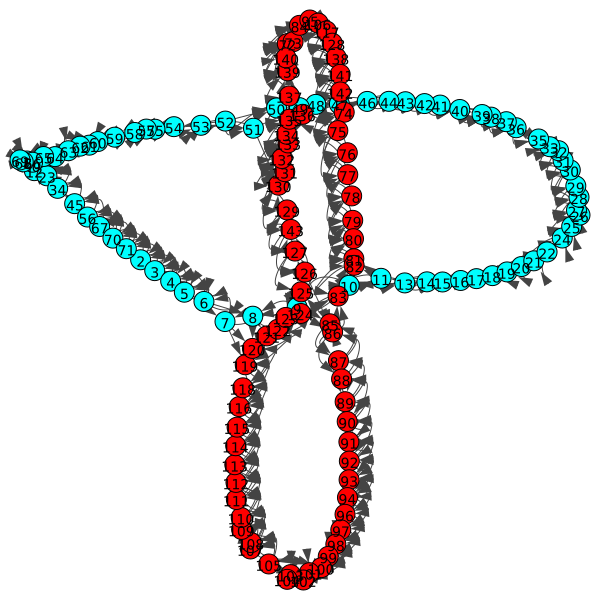

In [104]:
import random
random.seed(3)
ig.plot(G)

In [105]:
ari = adjusted_rand_score(targets, clusters[1])
ami = adjusted_mutual_info_score(targets, clusters[1])
print(f'ARI = {ari} and AMI = {ami}')

ARI = 0.3459128919134235 and AMI = 0.8114728707077318


## Connected components truncated UMAP matrix

The advantage of truncating the matrix by controlling the in-degree of the k-NN graph is that it allows to start with a larger k value, clean the high degree nodes, and 

In [106]:
A_w, knn_indices, knn_dists = knn_matrix(X=raw_data, k=10, return_all=True)

In [107]:
def restrict_indegree(A, max_keep):
    rows = np.array([])
    cols = np.array([])
    vals = np.array([])
    for i in range(A.shape[1]):
        candidate_rows = A.row[A.col==i]
        candidate_values = A.getcol(i).data
        permute = np.argsort(candidate_values)[::-1][0:max_keep]
        cols = np.concatenate([cols, [i]*len(permute)])
        rows = np.concatenate([rows, candidate_rows[permute]])
        vals = np.concatenate([vals, candidate_values[permute]])
    A_trunc = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=A.shape)
    return(A_trunc)

In [110]:
%%time
A_trunc = restrict_indegree(A_w.tocoo(), max_keep=3)
clusters = scipy.sparse.csgraph.connected_components(A_trunc)

CPU times: user 810 ms, sys: 0 ns, total: 810 ms
Wall time: 810 ms


In [111]:
Counter(clusters[1])

Counter({0: 72,
         1: 72,
         2: 216,
         3: 72,
         4: 72,
         5: 288,
         6: 72,
         7: 72,
         8: 72,
         9: 72,
         10: 72,
         11: 72,
         12: 72,
         13: 144})

In [112]:
A = A_trunc
w = clusters[1]==13
# w = np.isin(targets, [3, 6])
unique_cl = set(targets[w])
unique_color = RainbowPalette(n=len(unique_cl))
colors = dict({cl: unique_color[i] for i, cl in enumerate(unique_cl)})

A_adjacency = A.tocsr()[w, :].tocsc()[:, w]
G = ig.Graph.Weighted_Adjacency(A_adjacency)
G.simplify()
G.vs['target'] = targets[w]
G.vs['color'] = [colors[i] for i in G.vs['target']]

In [113]:
## Try how many triangles they are part of?
G.vs['label'] = [round(x, 2) for x in G.transitivity_local_undirected()]
G.vs['label'] = G.indegree()
# G.vs['label'] = G.outdegree()
# G.vs['label'] = [round(x/1000) for x in G.betweenness()]
G.vs['label'] = [v.index for v in G.vs]
#G.vs['label'] = G.vs['target']
#G.vs['label'] = [round(x, 2) for x in G.transitivity_local_undirected()]

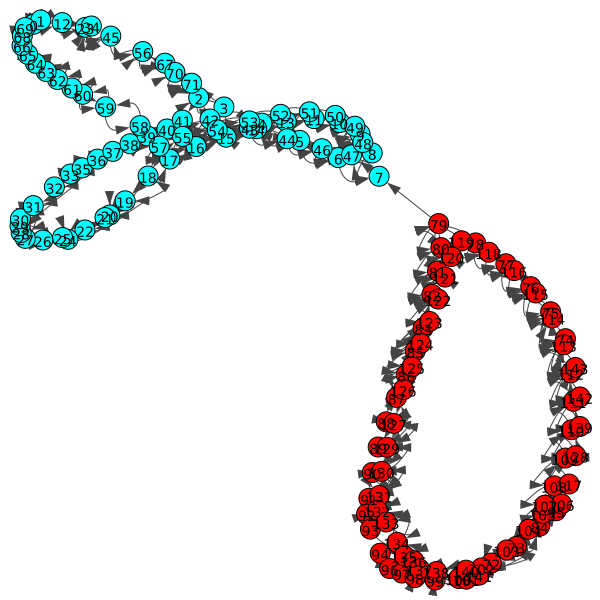

In [114]:
import random
random.seed(8)
ig.plot(G)

In [115]:
ari = adjusted_rand_score(targets, clusters[1])
ami = adjusted_mutual_info_score(targets, clusters[1])
print(f'ARI = {ari} and AMI = {ami}')

ARI = 0.6397997496871088 and AMI = 0.9034584004605596


# Iterate weights

In [116]:
dataset_id = 1
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

In [117]:
A_w, knn_indices, knn_dists = knn_matrix(X=raw_data, k=10, return_all=True)

In [118]:
# Everything created here is symmetric.

A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                 n_neighbors=10, 
                                                 random_state=0, 
                                                 metric='euclidean', 
                                                 return_dists=True,
                                                set_op_mix_ratio=1.0)

In [119]:
def restrict_indegree(A, max_keep):
    rows = np.array([])
    cols = np.array([])
    vals = np.array([])
    for i in range(A.shape[1]):
        candidate_rows = A.row[A.col==i]
        candidate_values = A.getcol(i).data
        permute = np.argsort(candidate_values)[::-1][0:max_keep]
        cols = np.concatenate([cols, [i]*len(permute)])
        rows = np.concatenate([rows, candidate_rows[permute]])
        vals = np.concatenate([vals, candidate_values[permute]])
    A_trunc = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=A.shape)
    return(A_trunc)

In [31]:
# def update_value_from_neighborhood(i, j, W, d): 
#     Wcsr = W.tocsr()
#     N1 = W.col[W.row==i]
#     N2 = W.col[W.row==j]
    
#     denom = d[i]*d[j]
    
#     new_w = len(set(N1).intersection(set(N2)))
#     new_w = (new_w + sum([Wcsr[n1,n2] for n1 in N1 for n2 in N2]))/denom
#     return(new_w)

In [32]:
# def umap_amplification_elementwise(W):
#     Wcoo = W.tocoo()
#     A = 1*(W!=0)
#     d = A.sum(axis=0).tolist()[0]
    
#     rows = np.array([])
#     cols = np.array([])
#     vals = np.array([])

#     for i in range(Wcoo.shape[1]):
#         candidate_rows = Wcoo.row[Wcoo.col==i]
#         sub_rows = [x for x in candidate_rows if x>i]
#         sub_vals = [update_value_from_neighborhood(i, j, Wcoo, d) for j in sub_rows]        
#         cols = np.concatenate([cols, [i]*len(sub_rows)])
#         rows = np.concatenate([rows, sub_rows])
#         vals = np.concatenate([vals, sub_vals])
#     W1 = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=W.shape)
#     return(W1.T+W1)

In [213]:
# For each non-zero entries of W we compute the average of the weights of the edges between
# the neighborhood of i and the neighborhood of j. 
# If some nodes apear in both neighborhoods, their edge weights are 1 - or 2?


def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

In [214]:
W = A_umap
alpha = 0.5
W1 = neighborhood_amplification(W, alpha**1)
W2 = neighborhood_amplification(W1, alpha**2)
W3 = neighborhood_amplification(W2, alpha**3)
W4 = neighborhood_amplification(W3, alpha**4)
W5 = neighborhood_amplification(W4, alpha**5)

Text(0.5, 1.0, 'After 5 iterations')

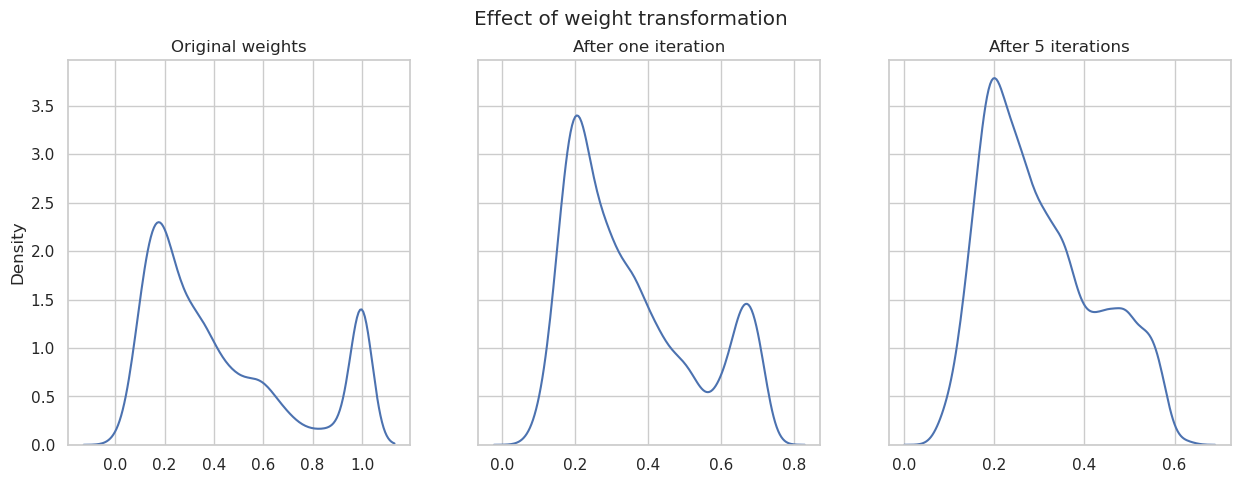

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Effect of weight transformation')

sns.kdeplot(W.data, ax=axes[0])
axes[0].set_title('Original weights')

sns.kdeplot(W1.data, ax=axes[1])
axes[1].set_title('After one iteration')

sns.kdeplot(W5.data, ax=axes[2])
axes[2].set_title('After 5 iterations')


In [216]:
w_df = pd.DataFrame({'x' :np.concatenate([W.data, W1.data, W5.data]), 
                    'Iterations' : np.concatenate([['Original weights']*len(W.data), ['1 iteration']*len(W.data), ['5 iterations']*len(W5.data)])})

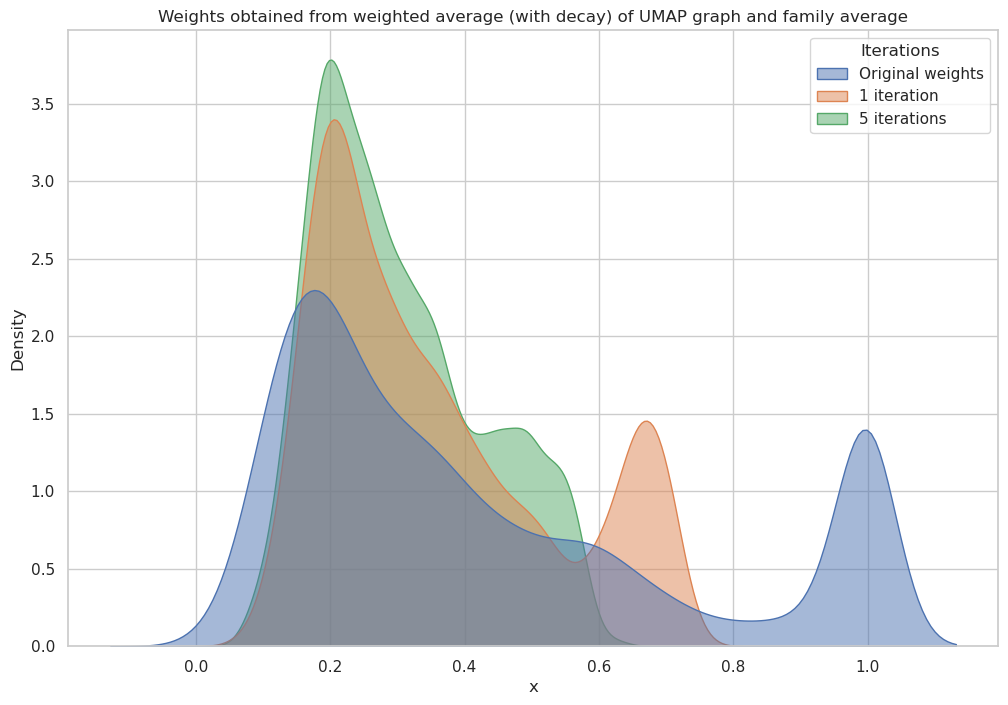

In [225]:
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

W = A_umap
alpha = 0.5
W1 = neighborhood_amplification(W, alpha**1)
W2 = neighborhood_amplification(W1, alpha**2)
W3 = neighborhood_amplification(W2, alpha**3)
W4 = neighborhood_amplification(W3, alpha**4)
W5 = neighborhood_amplification(W4, alpha**5)

w_df = pd.DataFrame({'x' :np.concatenate([W.data, W1.data, W5.data]), 
                    'Iterations' : np.concatenate([['Original weights']*len(W.data), ['1 iteration']*len(W.data), ['5 iterations']*len(W5.data)])})

# libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=w_df, x="x", hue="Iterations", fill=True, common_norm=False, alpha=0.5).set(title='Weights obtained from weighted average (with decay) of UMAP graph and family average')
plt.savefig('weighted_average_with_decay.png')
plt.show()

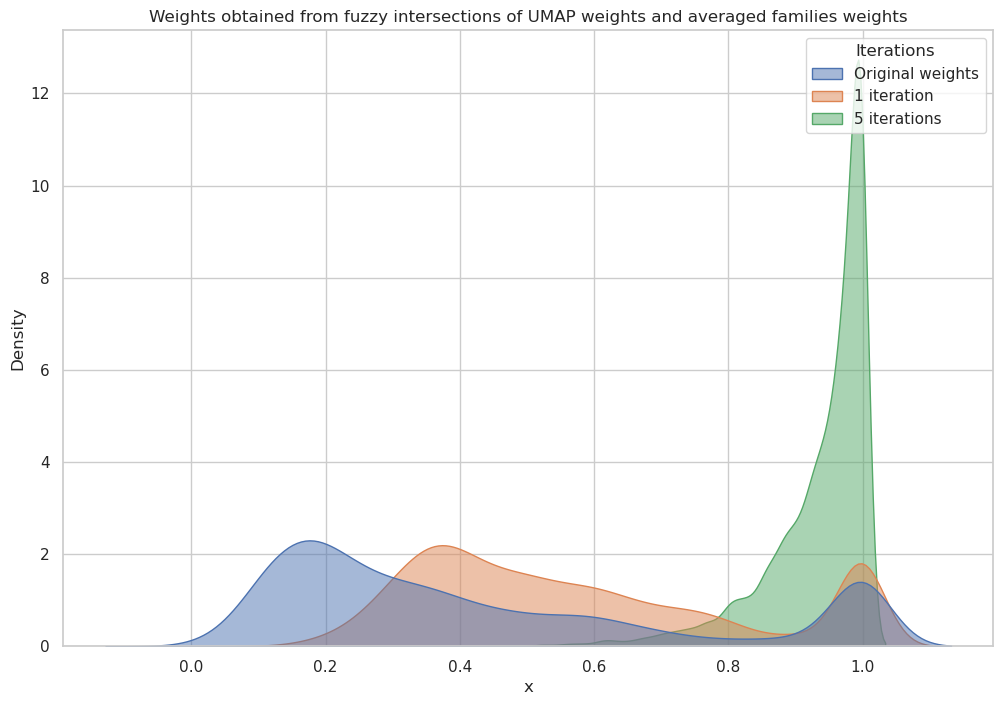

In [226]:
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    return(P)

W = A_umap
alpha = 0.5
W1 = neighborhood_amplification(W)
W2 = neighborhood_amplification(W1)
W3 = neighborhood_amplification(W2)
W4 = neighborhood_amplification(W3)
W5 = neighborhood_amplification(W4)

w_df = pd.DataFrame({'x' :np.concatenate([W.data, W1.data, W5.data]), 
                    'Iterations' : np.concatenate([['Original weights']*len(W.data), ['1 iteration']*len(W.data), ['5 iterations']*len(W5.data)])})

# libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=w_df, x="x", hue="Iterations", fill=True, common_norm=False, alpha=0.5).set(title='Weights obtained from fuzzy intersections of UMAP weights and averaged families weights')
plt.savefig('fuzzy_or.png')
plt.show()

In [128]:
W_trunc = restrict_indegree(W4.tocoo(), max_keep=3)
clusters = scipy.sparse.csgraph.connected_components(W_trunc)
Counter(clusters[1])

Counter({0: 72,
         1: 72,
         2: 29,
         3: 670,
         4: 63,
         5: 9,
         6: 32,
         7: 40,
         8: 72,
         9: 72,
         10: 67,
         11: 6,
         12: 72,
         13: 25,
         14: 47,
         15: 72,
         16: 12,
         17: 8})

In [135]:
all_clusters = clusters[1]

In [136]:
w_clusters = all_clusters

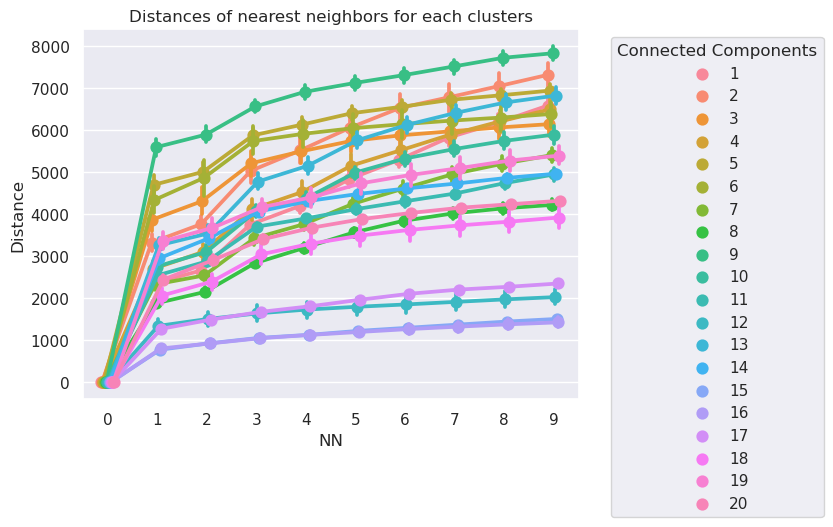

In [137]:
df_dists = pd.DataFrame([[x, y, targets[i], w_clusters[i]] for i, vector in enumerate(knn_dists) for x, y in enumerate(vector)], 
                        columns=['NN', 'Distance', 'Target', 'Connected component'])

restrict = None
#restrict = (df_dists['Connected component'].isin([9]))

if(restrict is None):
    restrict = np.array([True]*len(df_dists))

p = sns.pointplot(data=df_dists[restrict], x='NN', y='Distance', hue='Target', dodge=0.25)
p.set_title('Distances of nearest neighbors for each clusters')
p.legend(title='Connected Components', bbox_to_anchor=(1.05, 1), loc='upper left')

In [138]:
A_w, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                 n_neighbors=10, 
                                                 random_state=0, 
                                                 metric='euclidean', 
                                                 return_dists=True,
                                                set_op_mix_ratio=1.0)

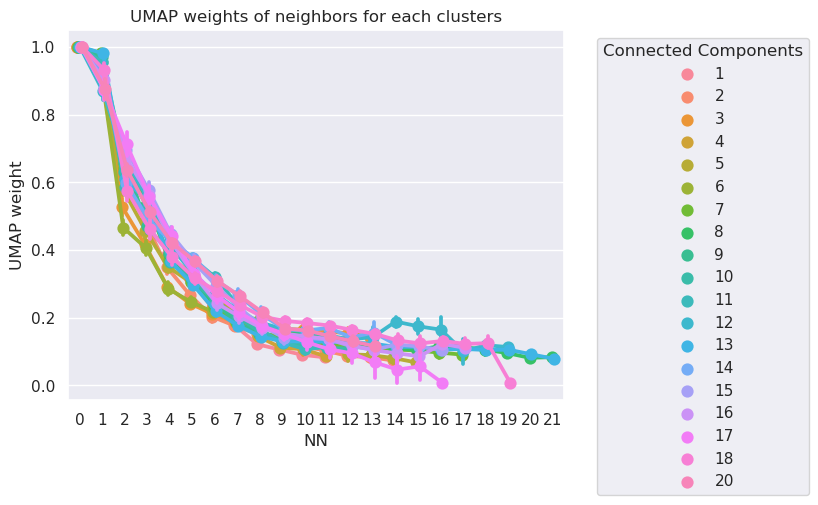

In [140]:
df_umap_ws = pd.DataFrame([[x, y, targets[i], w_clusters[i]] for i, vector in enumerate(A_umap) for x, y in enumerate(np.sort(vector.data)[::-1])], 
                        columns=['NN', 'UMAP weight', 'Target', 'Connected component'])

restrict = None
#restrict = (df_umap_ws['Connected component'].isin([9]))
restrict = (~df_umap_ws['Target'].isin([19]))

if(restrict is None):
    restrict = np.array([True]*len(df_umap_ws))

p = sns.pointplot(data=df_umap_ws[restrict], x='NN', y='UMAP weight', hue='Target', dodge=0.25)

p.set_title('UMAP weights of neighbors for each clusters')
p.legend(title='Connected Components', bbox_to_anchor=(1.05, 1), loc='upper left')